<a href="https://colab.research.google.com/github/AUT-Student/NN-HW8/blob/main/NN_HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Source

https://www.tensorflow.org/text/tutorials/transformer

# Library

In [1]:
!pip install tensorflow_text
!pip install tensorflow-probability

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import tensorflow_text

from keras.layers import Dense, Input, MultiHeadAttention, LayerNormalization, Layer, Embedding
from keras.models import Sequential
import keras.backend as K

# Dataset

In [3]:
dataset = tfds.load('ted_hrlr_translate/pt_to_en', with_info=False, as_supervised=True)

In [4]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]
valid_dataset = dataset["validation"]

# Tokenization

In [5]:
tokenizers_model_name = 'ted_hrlr_translate_pt_en_converter'
keras.utils.get_file(
    f'{tokenizers_model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{tokenizers_model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)

'./ted_hrlr_translate_pt_en_converter.zip'

In [6]:
tokenizers = tf.saved_model.load(tokenizers_model_name)
en_tokenizer = tokenizers.en
pt_tokenizer = tokenizers.pt

# Batching

In [7]:
en_length_list = np.zeros(0)
pt_length_list = np.zeros(0)
for pt_data, en_data in train_dataset.batch(4*1024):
  new_en_length_list = en_tokenizer.tokenize(en_data).row_lengths().numpy()
  new_pt_length_list = pt_tokenizer.tokenize(pt_data).row_lengths().numpy()

  en_length_list = np.concatenate((en_length_list, new_en_length_list))
  pt_length_list = np.concatenate((pt_length_list, new_pt_length_list))

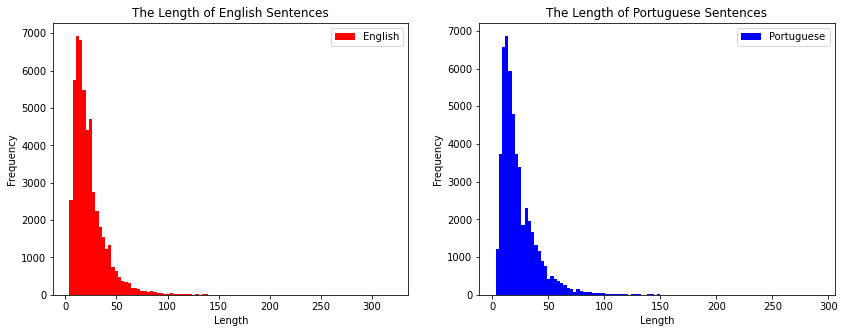

In [8]:
fig, ax = plt.subplots(1,2)

ax[0].hist(en_length_list, bins=100, color="red", label="English")
ax[1].hist(pt_length_list, bins=100, color="blue", label="Portuguese")
ax[0].legend()
ax[1].legend()
ax[0].set_title("The Length of English Sentences")
ax[1].set_title("The Length of Portuguese Sentences")
ax[0].set_xlabel("Length")
ax[1].set_xlabel("Length")
ax[0].set_ylabel("Frequency")
ax[1].set_ylabel("Frequency")

fig.set_size_inches(14, 5)
plt.show()

In [9]:
MAX_LENGTH = 128

In [10]:
def pad_dataset(dataset):
  new_dataset = []

  for pt_data, en_data in dataset.batch(1):
    en_tokens = en_tokenizer.tokenize(en_data).numpy()[0]
    pt_tokens = pt_tokenizer.tokenize(pt_data).numpy()[0]

    if len(en_tokens) > MAX_LENGTH or len(pt_tokens) > MAX_LENGTH:continue

    en_tokens = np.concatenate([en_tokens, np.zeros(MAX_LENGTH - len(en_tokens), np.int64)])
    pt_tokens = np.concatenate([pt_tokens, np.zeros(MAX_LENGTH - len(pt_tokens), np.int64)])

    new_dataset.append({"en": en_tokens, "pt": pt_tokens})

  new_dataset = pd.DataFrame(new_dataset)  
  return new_dataset

In [11]:
new_train_dataset = pad_dataset(train_dataset)

KeyboardInterrupt: ignored

In [ ]:
new_train_dataset.iloc[:10]

In [12]:
def filter_max_tokens(pt, en):
  num_tokens = tf.maximum(tf.shape(pt)[1],tf.shape(en)[1])
  return num_tokens < MAX_LENGTH

In [13]:
def tokenize_pairs(pt, en):
    pt = tokenizers.pt.tokenize(pt)
    pt = pt.to_tensor()

    en = tokenizers.en.tokenize(en)
    en = en.to_tensor()
    return pt, en

In [14]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [15]:
def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))


train_batches = make_batches(train_dataset)
valid_batches = make_batches(valid_dataset)

# Positional Encoding

In [16]:
def positional_encoding(position, d_model):
  encoding = np.zeros(d_model)

  for j in range(d_model):
    i = j//2
    angle = position/(10000**(2*i/d_model))

    if j%2==0:
      encoding[j] = np.sin(angle)
    else:
      encoding[j] = np.cos(angle)

  return encoding

In [17]:
positional_encoding_list = []
d_model = 128

for position in range(MAX_LENGTH):
  positional_encoding_list.append(positional_encoding(position, d_model))

positional_encoding_tensor = K.constant(positional_encoding_list)

# Masking

In [18]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  return seq[:, tf.newaxis, tf.newaxis, :]

In [19]:
def create_look_ahead_mask(size):
    n = int(size * (size+1) / 2)
    mask = tfp.math.fill_triangular(tf.ones((n,), dtype=tf.float32), upper=False)
    return mask

# Transformer FeedForward

In [20]:
class TransformerFeedForward(keras.Model):
  def __init__(self, d_feedforward, d_model):
    super().__init__()

    self.model = Sequential([
                             Dense(d_feedforward, activation="relu"),
                             Dense(d_model)

    ])
  
  def call(self, inputs):
    return self.model.call(inputs)

# Encoder Block

In [21]:
class EncoderBlock(Layer):
  def __init__(self, d_model, number_heads, d_feedforward):
    super().__init__()
    self.multi_head_attention = MultiHeadAttention(num_heads=number_heads, key_dim=d_model)

    self.feedforward = TransformerFeedForward(d_feedforward=d_feedforward, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)

  def call(self, x, mask):
    attention_output = self.multi_head_attention(x, x, x, mask)

    normal_output = self.normal_1(attention_output + x)

    feedforward_output = self.feedforward(normal_output)

    output = self.normal_2(feedforward_output + x) 

    return output

# Decoder Block

In [22]:
class DecoderBlock(Layer):
  def __init__(self, number_heads, d_feedforward, d_model):
    super().__init__()
    self.multi_head_attention_1 = MultiHeadAttention(num_heads=number_heads, key_dim=d_model)
    self.multi_head_attention_2 = MultiHeadAttention(num_heads=number_heads, key_dim=d_model)
    
    self.feedforward = TransformerFeedForward(d_feedforward=d_feedforward, d_model=d_model)

    self.normal_1 = LayerNormalization(epsilon=1e-6)
    self.normal_2 = LayerNormalization(epsilon=1e-6)
    self.normal_3 = LayerNormalization(epsilon=1e-6)

  def call(self, x, encoder_output, look_ahead_mask, padding_mask):    
    attention_output_1, attention_weights_1 = self.multi_head_attention_1(
        x, x, x, look_ahead_mask, return_attention_scores=True)

    normal_output_1 = self.normal_1(attention_output_1 + x)
    
    attention_output_2, attention_weights_2 = self.multi_head_attention_2(
        encoder_output, encoder_output, normal_output_1, padding_mask, return_attention_scores=True)

    normal_output_2 = self.normal_2(attention_output_2 + normal_output_1)

    feedforward_output = self.feedforward(normal_output_2)

    normal_output_3 = self.normal_3(feedforward_output + normal_output_2)

    return normal_output_3, attention_weights_1, attention_weights_2

# Encoder

In [23]:
class Encoder(Layer):
  def __init__(self, number_blocks, d_feedforward, d_model, source_vocab_size,
               number_heads, positional_encoding_tensor):
    super().__init__()
    self.positional_encoding_tensor = positional_encoding_tensor

    self.embedding = Embedding(source_vocab_size, d_model)

    self.number_blocks = number_blocks

    self.d_model = d_model

    self.encoder_blocks = []

    for _ in range(number_blocks):
      self.encoder_blocks.append(EncoderBlock(d_model=d_model, number_heads=number_heads, d_feedforward=d_feedforward))

  def call(self, x, mask):
    x = self.embedding(x)

    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    
    pe = self.positional_encoding_tensor[:x.shape[1], :]

    pe = tf.repeat(tf.expand_dims(pe, axis=0), axis=0, repeats=x.shape[0])

    x += pe

    for i in range(self.number_blocks):
      x = self.encoder_blocks[i](x, mask)

    return x 

# Decoder

In [24]:
class Decoder(Layer):
  def __init__(self, number_blocks, d_feedforward, d_model, number_heads,
               target_vocab_size, positional_encoding_tensor):
    super().__init__()
    self.positional_encoding_tensor = positional_encoding_tensor

    self.embedding = Embedding(target_vocab_size, d_model)

    self.number_blocks = number_blocks
    
    self.d_model = d_model

    self.decoder_blocks = []

    for _ in range(number_blocks):
      self.decoder_blocks.append(DecoderBlock(d_model=d_model, number_heads=number_heads, d_feedforward=d_feedforward))

  def call(self, x, encoder_output, look_ahead_mask, padding_mask):
      attention_weights = []

      x = self.embedding(x)
      x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))

      pe = self.positional_encoding_tensor[:x.shape[1], :]
      pe = tf.repeat(tf.expand_dims(pe, axis=0), axis=0, repeats=x.shape[0])
      x += pe

      for i in range(self.number_blocks):
        x, attention_weight_1, attention_weight_2 = self.decoder_blocks[i](x=x,
                                                           encoder_output=encoder_output,
                                                           look_ahead_mask=look_ahead_mask,
                                                           padding_mask=padding_mask)

        attention_weights.append({"1":attention_weight_1, "2":attention_weight_2})

      return x, attention_weights      


# Transformer

In [25]:
class Transformer(keras.Model):
  def __init__(self, number_encoder_blocks, number_decoder_blocks, number_heads,
               d_feedforward, d_model, source_vocab_size,
               target_vocab_size, positional_encoding_tensor):
    super().__init__()

    self.encoder = Encoder(number_blocks=number_encoder_blocks,
                           d_feedforward=d_feedforward, d_model=d_model,
                           source_vocab_size=source_vocab_size,
                           number_heads=number_heads,
                           positional_encoding_tensor=positional_encoding_tensor) 

    self.decoder = Decoder(number_blocks=number_decoder_blocks,
                           d_feedforward=d_feedforward, d_model=d_model,
                           number_heads=number_heads,
                           target_vocab_size=target_vocab_size,
                           positional_encoding_tensor=positional_encoding_tensor)

    self.last_layer = Dense(target_vocab_size)

  def create_masks(self, pt_inputs, en_inputs):
    padding_mask = create_padding_mask(pt_inputs)
    look_ahead_mask = create_look_ahead_mask(tf.shape(en_inputs)[1])
    dec_target_padding_mask = create_padding_mask(en_inputs)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return padding_mask, look_ahead_mask

  def call(self, inputs):
    pt_inputs, en_inputs = inputs

    padding_mask, look_ahead_mask = self.create_masks(pt_inputs, en_inputs)

    encoder_output = self.encoder(pt_inputs, padding_mask)

    decoder_output, attention_weights = self.decoder(
        en_inputs, encoder_output, look_ahead_mask, padding_mask)

    final_output = self.last_layer(decoder_output)

    return final_output, attention_weights

# Run

In [26]:
number_blocks = 4
d_model = 128
d_feedforward = 512
number_heads = 8

In [27]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [28]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [29]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [30]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [31]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

In [32]:
transformer = Transformer(number_encoder_blocks=number_blocks,
                          number_decoder_blocks=number_blocks,
                          number_heads=number_heads,
                          d_feedforward=d_feedforward, d_model=d_model,
                          source_vocab_size=pt_tokenizer.get_vocab_size().numpy(),
                          target_vocab_size=en_tokenizer.get_vocab_size().numpy(),
                          positional_encoding_tensor=positional_encoding_tensor)

In [33]:
# train_step_signature = [
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
#     tf.TensorSpec(shape=(None, None), dtype=tf.int64),
# ]

# @tf.function(input_signature=train_step_signature)
def train_step(inp, tar):

  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp])
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
import time 
for epoch in range(5):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    inp = tf.pad(tensor=inp, paddings=tf.constant([[0, 0], [0, MAX_LENGTH-inp.shape[1]]]))
    tar = tf.pad(tensor=tar, paddings=tf.constant([[0, 0], [0, MAX_LENGTH-tar.shape[1]+1]]))

    train_step(inp, tar)

    if batch % 5 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 8.8526 Accuracy 0.0000
Epoch 1 Batch 5 Loss 8.8582 Accuracy 0.0001
Epoch 1 Batch 10 Loss 8.8568 Accuracy 0.0001
Epoch 1 Batch 15 Loss 8.8527 Accuracy 0.0000
Epoch 1 Batch 20 Loss 8.8481 Accuracy 0.0000
Epoch 1 Batch 25 Loss 8.8398 Accuracy 0.0000
Epoch 1 Batch 30 Loss 8.8293 Accuracy 0.0010
Epoch 1 Batch 35 Loss 8.8189 Accuracy 0.0026
Epoch 1 Batch 40 Loss 8.8076 Accuracy 0.0059
Epoch 1 Batch 45 Loss 8.7966 Accuracy 0.0098
Epoch 1 Batch 50 Loss 8.7849 Accuracy 0.0131
Epoch 1 Batch 55 Loss 8.7729 Accuracy 0.0160
Epoch 1 Batch 60 Loss 8.7604 Accuracy 0.0187
Epoch 1 Batch 65 Loss 8.7489 Accuracy 0.0208
Epoch 1 Batch 70 Loss 8.7373 Accuracy 0.0224
Epoch 1 Batch 75 Loss 8.7260 Accuracy 0.0239
Epoch 1 Batch 80 Loss 8.7153 Accuracy 0.0251
Epoch 1 Batch 85 Loss 8.7038 Accuracy 0.0263
Epoch 1 Batch 90 Loss 8.6925 Accuracy 0.0273
Epoch 1 Batch 95 Loss 8.6810 Accuracy 0.0284
Epoch 1 Batch 100 Loss 8.6695 Accuracy 0.0293
Epoch 1 Batch 105 Loss 8.6584 Accuracy 0.0300
Epoch 1 Ba